In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import os


In [9]:
# Load the transaction data
df = pd.read_csv("data/bank_transactions.csv")
df.dropna(inplace=True)

# encode all variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])


In [10]:
# drop non-feature columns
X = df.drop(columns=[
    "TransactionID", "AccountID", "TransactionDate",
    "IP Address", "DeviceID", "MerchantID"
], errors='ignore')


In [11]:
# create and fit the anomaly detection model
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
model.fit(X)

# get predictions
df['anomaly_score'] = model.decision_function(X)
df['is_anomaly'] = pd.Series(model.predict(X)).map({1: 0, -1: 1})  # 1 = suspicious


In [13]:
# print basic stats about anomaly detection
total = len(df)
anomalies = df['is_anomaly'].sum()
print(f"\n {anomalies} out of {total} transactions flagged as suspicious ({(anomalies/total)*100:.2f}%)")



 51 out of 2512 transactions flagged as suspicious (2.03%)


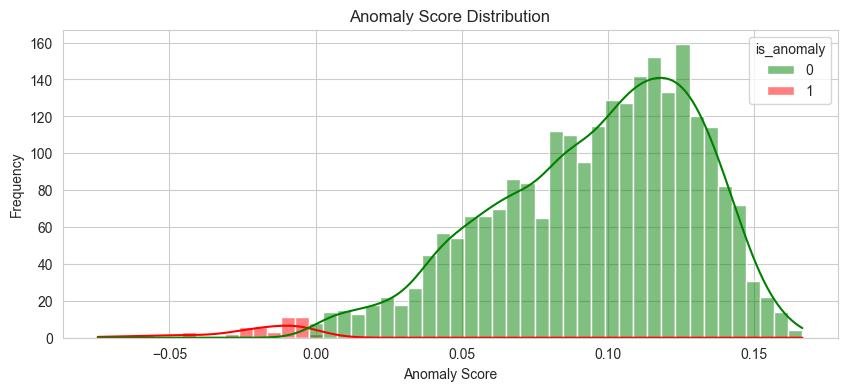

In [14]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='anomaly_score', bins=50, kde=True, hue='is_anomaly', palette={0: "green", 1: "red"})
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


In [15]:
print("\nTop 10 Most Suspicious Transactions:")
print(df.sort_values(by='anomaly_score').head(10)[[
    'TransactionAmount', 'LoginAttempts', 'TransactionType',
    'Channel', 'CustomerAge', 'anomaly_score'
]])



Top 10 Most Suspicious Transactions:
      TransactionAmount  LoginAttempts  TransactionType  Channel  CustomerAge  \
274             1176.28              5                0        0           54   
1557             262.43              5                0        2           37   
2073             441.26              5                0        1           58   
693              733.29              5                1        0           52   
898             1531.31              4                1        2           18   
691               25.94              5                0        2           58   
2423             332.06              4                1        0           29   
394                6.30              5                1        1           80   
1213            1192.20              5                0        1           60   
2124             737.46              4                0        1           53   

      anomaly_score  
274       -0.074486  
1557      -0.067774  
2073

FEATURE COMPARISON: NORMAL VS SUSPICIOUS

/var/folders/p4/f_hczl2574x6xsbjl5qymcz40000gn/T/ipykernel_84207/23202548.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_anomaly', y=feature, data=df, palette="Set2")


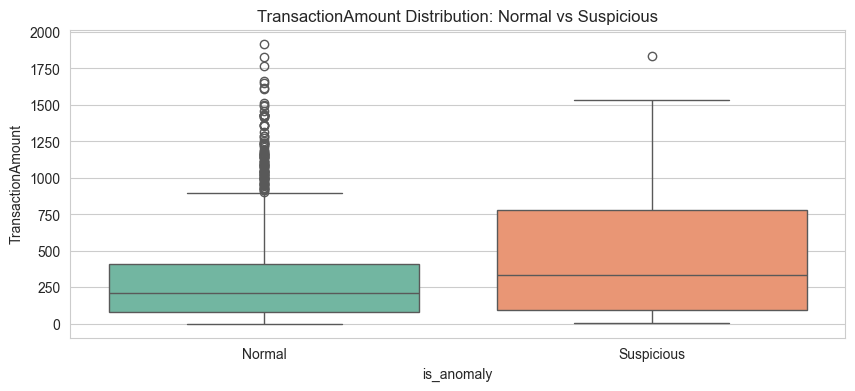

/var/folders/p4/f_hczl2574x6xsbjl5qymcz40000gn/T/ipykernel_84207/23202548.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_anomaly', y=feature, data=df, palette="Set2")


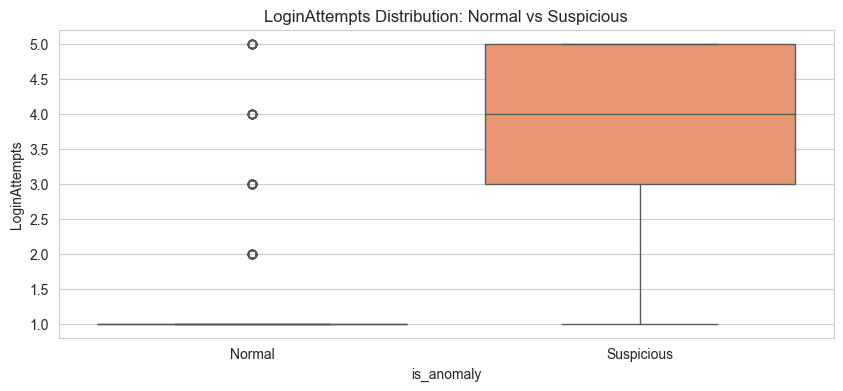

/var/folders/p4/f_hczl2574x6xsbjl5qymcz40000gn/T/ipykernel_84207/23202548.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_anomaly', y=feature, data=df, palette="Set2")


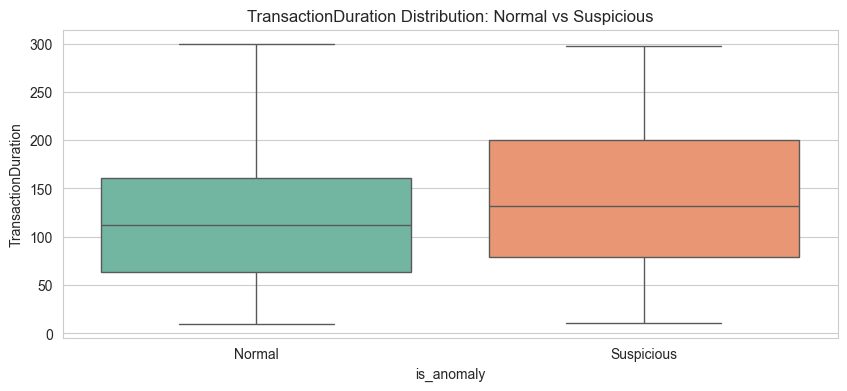

/var/folders/p4/f_hczl2574x6xsbjl5qymcz40000gn/T/ipykernel_84207/23202548.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_anomaly', y=feature, data=df, palette="Set2")


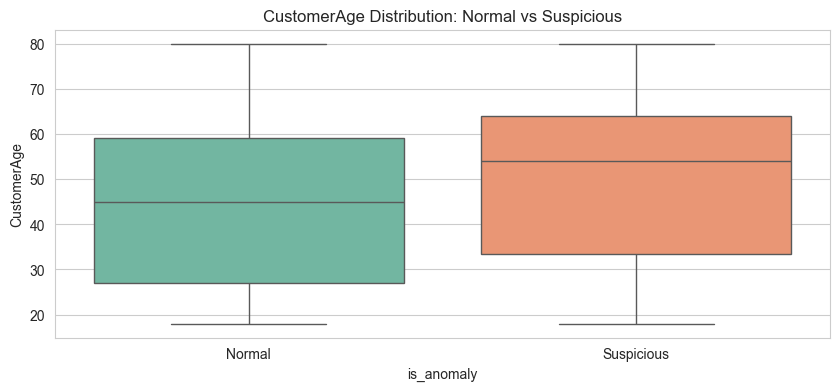

In [16]:
features_to_check = ['TransactionAmount', 'LoginAttempts', 'TransactionDuration', 'CustomerAge']
for feature in features_to_check:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='is_anomaly', y=feature, data=df, palette="Set2")
    plt.title(f"{feature} Distribution: Normal vs Suspicious")
    plt.xticks([0, 1], ['Normal', 'Suspicious'])
    plt.show()


In [17]:
comparison = df.groupby('is_anomaly')[features_to_check].mean().T
comparison.columns = ['Normal_Avg', 'Suspicious_Avg']
print("\n Mean Feature Values (Suspicious vs Normal):")
print(comparison)



 Mean Feature Values (Suspicious vs Normal):
                     Normal_Avg  Suspicious_Avg
TransactionAmount    293.262438      506.602157
LoginAttempts          1.072328        3.647059
TransactionDuration  119.147501      143.568627
CustomerAge           44.563186       50.019608


In [18]:
os.makedirs("output", exist_ok=True)
comparison.to_csv("output/fraud_feature_insights.csv")
